# Linear discriminant analysis


## Introduction

In this notebook we will study the Linear discriminant analysis (LDA) and implement it using pure numpy. LDA is a classification algorithm and it relies on heavy assumptions about the underlaying distribution of the points to be classified. This makes it quite restrictive, but very robust in practice and easy to implement, making it one of the most popular choices for classification problems.

## The model

Suppose we are given observations  $\{(x_1,y_1),\dots,(x_m,y_m)\}\subset \mathbb{R}^n\times F$ where $F$ is a finite set (which we will identify with $\{0,\dots,K-1 \}$, where $k=\# F$). For each class $j$, we have a prior probability $\pi_j$ (so $\sum_j \pi_j = 1$) representing the probability that a randomly sampled observation comes from the class $j$. We will assume that the conditional density of $X$ for each class is Gaussian with the **same covariance matrix**, that is,
$$
p(x \ | \ y = k) = \dfrac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}\exp(-\dfrac{1}{2}(x-\mu_k)^T\Sigma^{-1}(x-\mu_k))
$$
where $\mu_k$ is the mean of each class and $\Sigma$ is the covariance matrix common to all classes. Let $x\in\mathbb{R}^n$ be a point for which we want to predict the class $y$ it belongs to. By the Bayes theorem
$$
\mathbb{P}(y = k \ | \ x) = \dfrac{p(x \ | \ y = k)\pi_k}{\sum_{i=0}^{K-1}p(x \ | \ y = i)\pi_i  }.
$$
The Bayes discriminant rules predicts $y=k$ for the value of $k$ that maximizes $\mathbb{P}(y = k \ | \ x) $. Note that the denominator is common for all classes, so in practice we maximize $p(x \ | \ y = k)\pi_k$. In order to do so, denote $k^* = \mathrm{argmax}_k\mathbb{P}(y = k \ | \ x) $ and note that is equivalent to
$$
k^* = \underset{k}{\mathrm{argmax}} \log\left(  \dfrac{\mathbb{P}(y = k \ | \ x) }{\mathbb{P}(y = i \ | \ x) } \right)
$$
where the maximum is taken with respect to $k$ and $i$. Since we know the conditional density of each class, we can compute the above expression explicitly:
\begin{align*}
\log\left(  \dfrac{\mathbb{P}(y = k \ | \ x) }{\mathbb{P}(y = i \ | \ x) } \right) &= \log\dfrac{\pi_k}{\pi_i} + \log\dfrac{p(x \ | \ y = k)}{p(x \ | \ y = i)} \\
&= \log\dfrac{\pi_k}{\pi_i} +\dfrac{1}{2}(x^T\Sigma^{-1}\mu_k+\mu_k^T\Sigma^{-1}x-\mu_k^T\Sigma^{-1}\mu_k - x^T\Sigma^{-1}\mu_i-\mu_i^T\Sigma^{-1}x+\mu_i^T\Sigma^{-1}\mu_i  ) \\
&= \log\dfrac{\pi_k}{\pi_i} + x^T\Sigma^{-1}(\mu_k-\mu_i) +\dfrac{1}{2}( \mu^T_i\Sigma^{-1}\mu_i - \mu^T_k\Sigma^{-1}\mu_k )\\
&= \log\dfrac{\pi_k}{\pi_i} + x^T\Sigma^{-1}(\mu_k-\mu_i) - \dfrac{1}{2}(\mu_k+\mu_i)^T\Sigma^{-1}(\mu_k-\mu_i) \\
&= \delta_k(x) - \delta_i(x)
\end{align*}
where $\delta_k(x)=\log \pi_k + x^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu_k\Sigma^{-1}\mu_k$. Note then that $k^* = \underset{k}{\mathrm{argmax\ }} \delta_k(x)$. Now, in order to solve this optimization problem, we need $\pi_k$ $\mu_k$ and $\Sigma$. Since we do not know in advance these values, we can estimate them using our training data. We use the following estimators:

$
\begin{align}
\hat{\pi}_k &= \dfrac{\#\{ i : y_i = k\}}{m} \\
\hat{\mu_k}& = \dfrac{1}{\#\{ i : y_i = k\}}\sum_{y_i=k} x_i \\
\hat{\Sigma}&=\dfrac{1}{m-K+1}\sum_{k=0}^{K-1}\sum_{y_i=k}(x_i-\hat{\mu}_k)(x_i-\hat{\mu}_k)^T
\end{align}
$

With this we can fully write our prediction function: for a new point $x$, we predict the class $k*$ given by
$$
k^* = \underset{k}{\mathrm{argmax\ }} \delta_k(x).
$$
We proceed to implement this algorithm.

## Implementation

We start by importing the usual libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We generate three clouds of points with Gaussian conditional distribution having the same covariance matrix:

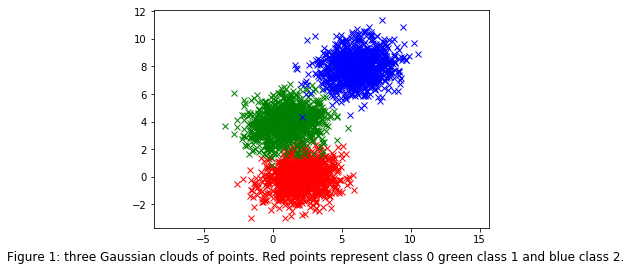

In [2]:
class_0 = 1000 #num obs from each class
class_1 = 1000
class_2 = 1000
x0 = np.random.multivariate_normal([2, 0], [[2, .25],[.25, 1]], class_0)
x1 = np.random.multivariate_normal([1, 4], [[2, .25],[.25, 1]], class_1)
x2 = np.random.multivariate_normal([6, 8], [[2, .25],[.25, 1]], class_1)

plt.plot(x0[:,0],x0[:,1],'x',color='red')
plt.plot(x1[:,0],x1[:,1],'x',color='green')
plt.plot(x2[:,0],x2[:,1],'x',color='blue')
plt.figtext(0.5, 0.01, 'Figure 1: three Gaussian clouds of points. Red points represent class 0 green class 1 and blue class 2.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.axis('equal')
plt.show()

We now generate a vector of labels for each of the points in each of the clouds:

In [3]:
y0 = np.zeros(len(x0))
y1 = np.ones(len(x1))
y2 = 2*np.ones(len(x2))

X_train =  np.vstack((x0,x1,x2))
Y_train = np.append(np.append(y0,y1),y2)

We estimate the prior probabilities $\pi_k$ of each class:

In [4]:
pi_0 = sum(Y_train == 0)/len(Y_train)
pi_1 = sum(Y_train == 1)/len(Y_train)
pi_2 = sum(Y_train == 2)/len(Y_train)
prior = [pi_0,pi_1,pi_2]

Now we estimate the mean $\mu_k$ of each class

In [5]:
W = np.hstack((X_train,Y_train.reshape(-1,1)))
mu_0 = np.mean(W[W[:,-1] == 0],axis=0)[:-1]
mu_1 = np.mean(W[W[:,-1] == 1],axis=0)[:-1]
mu_2 = np.mean(W[W[:,-1] == 2],axis=0)[:-1]
mu = [mu_0,mu_1,mu_2]

We now estimate the covariance matrix $\Sigma$ and compute its inverse $\Sigma^{-1}$:

In [6]:
sigma = 0
for i in range(3):
    sigma += np.dot((X_train[W[:,-1] == i] - mu[i]).T,(X_train[W[:,-1] == i] - mu[i]))/(len(X_train)-3)
inv_sigma = np.linalg.inv(sigma) 

Finally we can compute the decision function $\delta_k(x)$:

In [7]:
def delta(k,x):
    return (np.dot(np.dot((x.reshape(-1,1)).T,inv_sigma),mu[k]) - (1/2)*np.dot(np.dot(mu[k].T,inv_sigma),mu[k]) 
            + np.log(prior[k]))

With this, we can make our predictions:

In [8]:
def prediction(x):
    L = []
    for k in range(3):
        L.append(delta(k,x))
    return np.argmax(L)

Let us try this function for the points $(2,0),(1,4),(6,8)$, corresponding to the (real) means of classes $0,1,2$ respectively: 

In [9]:
prediction(np.array([2,0])) , prediction(np.array([1,4])), prediction(np.array([6,8]))

(0, 1, 2)

Finally we can draw the decision boundary of the predictions given by the algorithm:

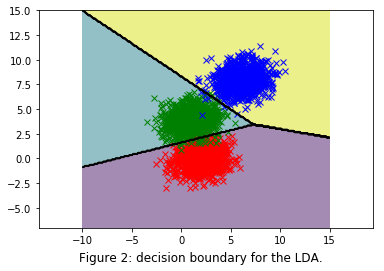

In [10]:
x = np.linspace(-10, 15, 200)
y = np.linspace(-7, 15, 200)
X, Y = np.meshgrid(x, y)
z = np.zeros(X.shape)
Z = np.array(z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = prediction(np.array([x[j],y[i]]))
plt.contourf(X, Y, Z, alpha=.5)
C = plt.contour(X, Y, Z,  colors='black',zorder=4)
plt.plot(x0[:,0],x0[:,1],'x',color='red',zorder=1)
plt.plot(x1[:,0],x1[:,1],'x',color='green',zorder=2)
plt.plot(x2[:,0],x2[:,1],'x',color='blue',zorder=3)
plt.axis('equal')
plt.figtext(0.5, 0.01, 'Figure 2: decision boundary for the LDA.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()